# **CSE4022 - NATURAL LANGUAGE PROCESSING**



    > **PROJECT COMPONENT**
    TEAM MEMBERS - ILAKKIYA V (19BCE1699) and YUKTI S (19BCE1665)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#mounting the drive and redirecting to folder
 
%cd /content/drive/My\Drive/nlp_proj

/content/drive/MyDrive/nlp_proj


In [ ]:
root = '/content/drive/MyDrive/nlp_proj/en-ta-parallel-v2/en-ta-parallel-v2'

# **Import Packages**

In [ ]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
import string
import re
import pickle

from __future__ import print_function
from matplotlib import pylab
from matplotlib.font_manager import FontProperties
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

%matplotlib inline
tamil_font = FontProperties(fname=os.path.join('vijaya.ttf'))

# **Clean Data**



   > The dataset was obtained from https://ufal.mff.cuni.cz/~ramasamy/parallel/html/

They have collected English-Tamil bilingual data from some of the publicly available websites for NLP research involving Tamil. The standard set of processing has been applied on the the raw web data before the data became available in sentence aligned English-Tamil parallel corpus suitable for various NLP tasks. The parallel corpora cover texts from bible, cinema and news domains

In [ ]:
def clean_text(sentence, language):
    """
        Input: String, String
        Output: String
        Takes in text as string. Returns text cleaned for NMT purposes.
    """
    if language == None:
        print("Please enter which language.")
        return None
        
    exclude = set(string.punctuation)
    remove_digits = str.maketrans('', '', string.digits)
        
    if language == 'en':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    elif language == 'hi':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)

        sent_temp = ''
        for c in sentence:
            if c == ' ':
                sent_temp += c
            elif ord(u'\u0900') <= ord(c) <= ord(u'\u097F'):
                sent_temp += c
        sentence = sent_temp
      
        sentence = re.sub('[a-z]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    elif language == 'ta':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = re.sub('[a-z]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    else:
        print("Language not found")
        return None

# **Preprocessing Data**

In [ ]:
def read_data(filename, number_of_lines):
    data = list()
    
    with open(os.path.join(root, filename)) as f:
        for i in  range(number_of_lines):
            data.extend(clean_text(tf.compat.as_str(f.readline()).strip(), 'ta').split(' '))
    return data

words = read_data('corpus.bcn.dev.ta', 5000000)
print("Data size %d" % len(words))

Data size 5014813


In [ ]:
words

['சவுலுக்கு',
 'இருந்த',
 'குமாரர்',
 'யோனத்தான்',
 'இஸ்வி',
 'மல்கிசூவா',
 'என்பவர்கள்',
 'அவனுடைய',
 'இரண்டு',
 'குமாரத்திகளில்',
 'மூத்தவள்',
 'பேர்',
 'மோப்',
 'இளையவள்',
 'பேர்',
 'மீகாள்',
 'அஹமதினேஜாத்',
 'இஸ்ரேலை',
 'ஆதரிக்கும்',
 'போர்',
 'குற்றவாளிகள்',
 'பற்றியும்',
 'மற்றும்',
 'பிற',
 'நாடுகளில்',
 'தங்களுக்கே',
 'பாதுகாப்பு',
 'தேடிக்',
 'கொள்வதற்காக',
 'போர்களை',
 'நடத்திக்',
 'கொண்டிருப்பவர்கள்',
 'பற்றியும்',
 'மறைமுகமாக',
 'குறிப்பிட்டார்',
 'சர்வதேச',
 'பொது',
 'மன்னிப்பு',
 'சபை',
 'ஒரு',
 'புலன்',
 'விசாரணை',
 'நடத்த',
 'வேண்டும்',
 'என்று',
 'கேட்டுக்',
 'கொண்டது',
 'பாலஸ்தீன',
 'அரசு',
 'என்று',
 'கூறப்படும்',
 'ஒட்டுமொத்த',
 'நடவடிக்கைகளும்',
 'அது',
 'தொடர்பான',
 'அனைத்து',
 'தொடர்',
 'நடவடிக்கைகளும்',
 'எங்களது',
 'நிகழ்ச்சி',
 'நிரலில்',
 'இருந்து',
 'காலவரையின்றி',
 'விலக்கப்பட்டுவிட்டன',
 'ஆயினும்',
 'இந்த',
 'அரசியல்வாதிகள்',
 'தேர்தல்',
 'நெருங்குவதன்',
 'காரணமாக',
 'எங்களை',
 'காண',
 'வருகின்றனர்',
 'என்று',
 'வெறுப்புணர்வுடன்',
 'அவர்',
 'கூறின

# **Most words in Vocabulary**

In [ ]:
vocabulary_size = int(len(set(words)) // 1.2)

def build_dataset(words):
    count = [['தமிழ்', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print("Vocabulary size", vocabulary_size)
print("Most common words (+தமிழ்)", count[:5])
print("Sample data", data[:10])
del words

Vocabulary size 7415
Most common words (+தமிழ்) [['தமிழ்', 1485], ('', 4999003), ('மற்றும்', 163), ('ஒரு', 161), ('என்று', 120)]
Sample data [1934, 61, 970, 1935, 1936, 1937, 971, 626, 34, 1938]


# **WORD2VEC**

In [ ]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print("Data:", [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print("\nwith num_skips = %d and skip_window = %d:" % (num_skips, skip_window))
    print("    batch:", [reverse_dictionary[bi] for bi in batch])
    print("    labels:", [reverse_dictionary[di] for di in labels.reshape(8)])

Data: ['சவுலுக்கு', 'இருந்த', 'குமாரர்', 'யோனத்தான்', 'இஸ்வி', 'மல்கிசூவா', 'என்பவர்கள்', 'அவனுடைய']

with num_skips = 2 and skip_window = 1:
    batch: ['இருந்த', 'இருந்த', 'குமாரர்', 'குமாரர்', 'யோனத்தான்', 'யோனத்தான்', 'இஸ்வி', 'இஸ்வி']
    labels: ['சவுலுக்கு', 'குமாரர்', 'இருந்த', 'யோனத்தான்', 'இஸ்வி', 'குமாரர்', 'மல்கிசூவா', 'யோனத்தான்']

with num_skips = 4 and skip_window = 2:
    batch: ['குமாரர்', 'குமாரர்', 'குமாரர்', 'குமாரர்', 'யோனத்தான்', 'யோனத்தான்', 'யோனத்தான்', 'யோனத்தான்']
    labels: ['இருந்த', 'இஸ்வி', 'யோனத்தான்', 'சவுலுக்கு', 'இஸ்வி', 'இருந்த', 'குமாரர்', 'மல்கிசூவா']


# **Tensorflow implementation**

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                    labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset:batch_data, train_labels:batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            
            print("Average loss at step %d: %f" % (step, average_loss))
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 5.202567
Nearest to ஆகும்: ஆப்பாக், பிரிவுகளின், நீண்டகாலப்போக்கில், பயங்கரவாதத்திற்கு, பாதியையும், ஷாங்காய், நாடுகளில், அதற்கான,
Nearest to இதில்: ஈடுபட்டுள்ளார், ஏற்படுத்த, முஸ்லீம்களுக்கு, நந்தலாலாவுக்கு, வாக்குச், பிரகடனம், அரசியல்ரீதியான, புசித்தவன்,
Nearest to தேசிய: உண்டாக்கி, தொடங்கி, குழுக்களுக்குள்ளேயே, சர்ச்சையில், இருப்பினும், தோன்ற, ஊடகங்களில், காணமுடியாத,
Nearest to இராணுவ: ஏகமாய், விளக்க, பாக்கி, ஏகாதிபத்தியத்தியம், விருதாவாக்குகிறதில்லை, பப்புவா, நலன்கள், அவகாசம்,
Nearest to கூறினார்: திவாலுக்கு, வெடிப்புக்களுக்கு, ஒன்று, உள்நாட்டு, வழங்குவதை, தூக்கிலிடப்பட்டதையிட்டு, ஆத்துமாவே, சுட்டுக்கொன்றது,
Nearest to சில: ஆட்சியிலிருந்து, சிறுநகரங்கள், தமிழ்த், கொடுத்தேன், சங்கிலியால், பங்குகளை, சபையின், இழிந்த,
Nearest to வகையில்: சொத்துக்களை, ஆசைப்பட்ட, எவ்விதமான, பெற்றது, நிற்பது, பணிகளை, தாக்கப்பட்டது, திறனைத்,
Nearest to ஜனநாயக: அசாதாரணமான, தோழமைக், விட்டதாகவும், பிரபலமாகி, கட்டுப்படுத்தவும், கூடுதல், தீர்க்கதரிசிகளைக்குறித்து, ஒப்பந்

# **Visualization of the output**

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


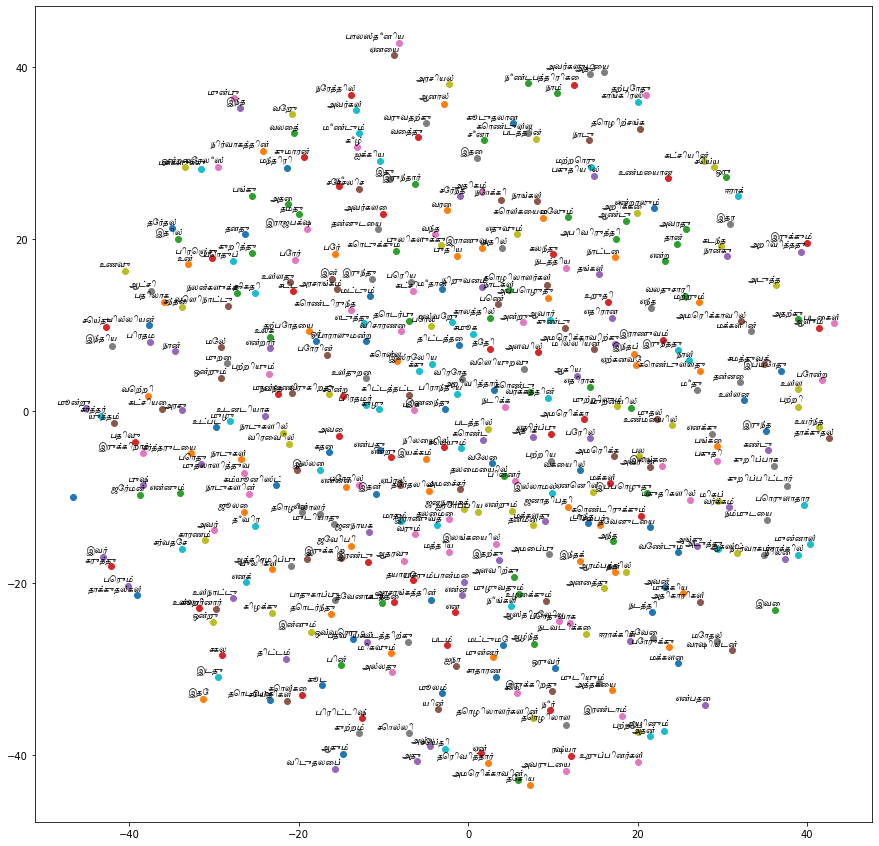

In [ ]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=tamil_font)
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [ ]:
final_data = {
    'embeddings': final_embeddings,
    'dictionary': dictionary,
    'reverse_dictionary': reverse_dictionary
}

In [ ]:
with open(os.path.join('embeddings_sg.ta'), 'wb') as f:
    pickle.dump(file=f, obj=final_data)